In [1]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

Fitted parameters:
Gaussian 1: A=0.97, mu=0.25, sigma=0.04
Gaussian 2: A=0.86, mu=0.74, sigma=0.03
Fitted parameters:
Gaussian 1: A=0.88, mu=0.19, sigma=0.03
Gaussian 2: A=0.04, mu=0.46, sigma=1.00
Gaussian 3: A=0.93, mu=0.53, sigma=0.03
Fitted parameters:
Gaussian 1: A=0.53, mu=0.38, sigma=0.03
Gaussian 2: A=0.04, mu=0.65, sigma=0.10
Gaussian 3: A=0.60, mu=0.72, sigma=0.05
Gaussian 4: A=0.21, mu=0.79, sigma=0.09
Gaussian 5: A=0.82, mu=0.85, sigma=0.03
Fitted parameters:
Gaussian 1: A=0.96, mu=0.13, sigma=0.03
Gaussian 2: A=0.67, mu=0.27, sigma=0.03
Gaussian 3: A=0.03, mu=0.62, sigma=1.00
Gaussian 4: A=0.64, mu=0.69, sigma=0.05
Gaussian 5: A=0.08, mu=0.77, sigma=0.04
Fitted parameters:
Gaussian 1: A=0.03, mu=0.28, sigma=1.00
Gaussian 2: A=0.82, mu=0.36, sigma=0.06
Gaussian 3: A=0.06, mu=0.46, sigma=0.09
Gaussian 4: A=0.90, mu=0.52, sigma=0.02
Gaussian 5: A=0.57, mu=0.69, sigma=0.02


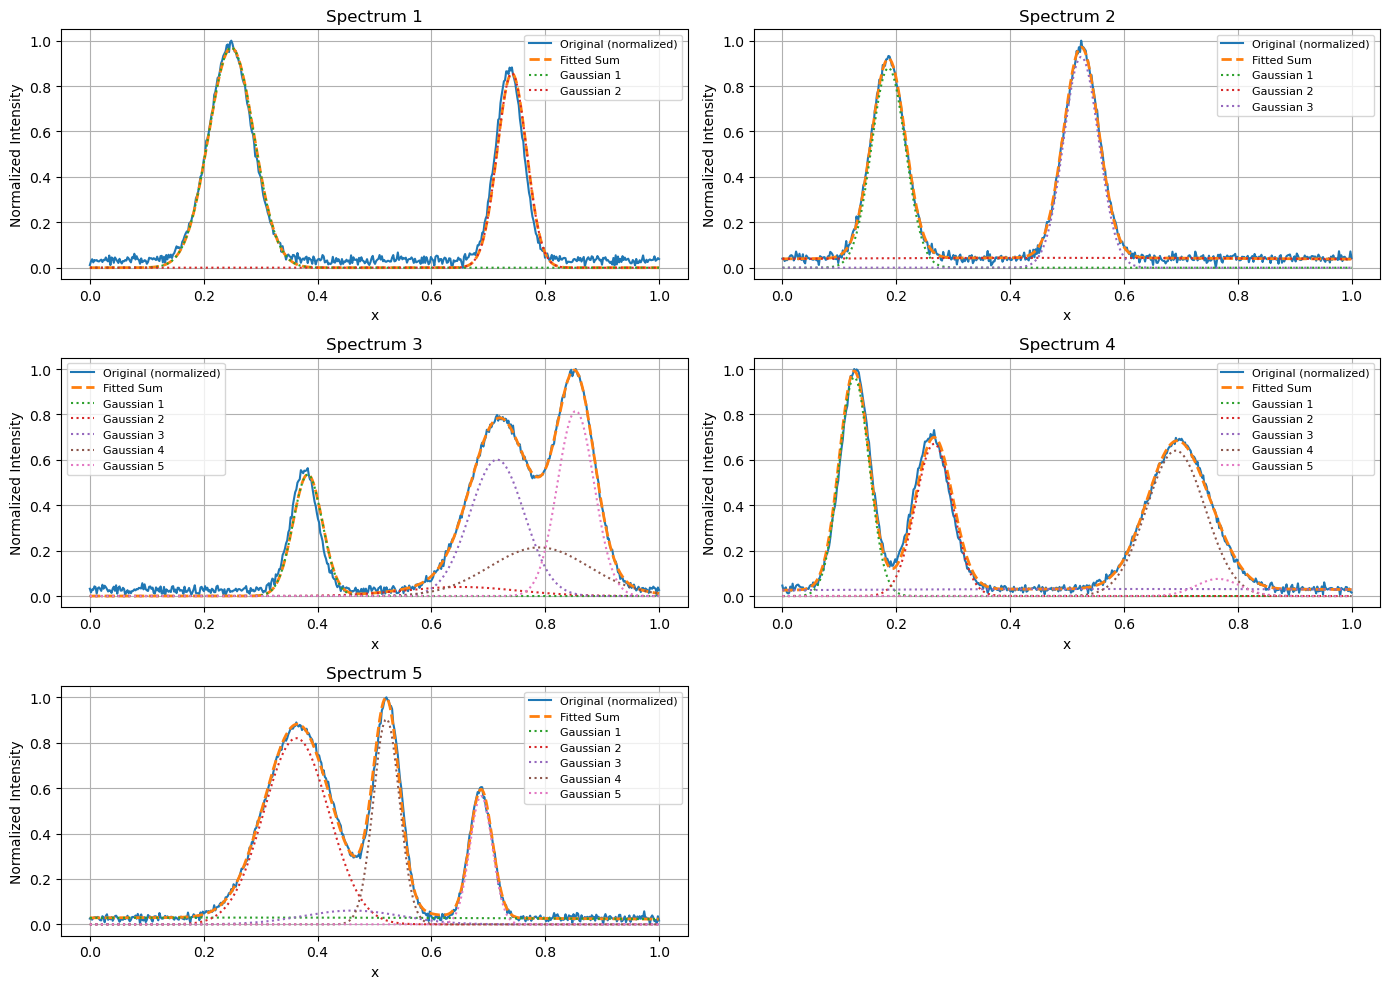

In [2]:

# === Gaussian fitting function with constraints ===
def fit_gaussian_peak(i1):
    i1 = np.array(i1)

    def peakfunc(x, A, mu, sigma):
        return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

    def gaussian_sum(x, *params):
        n = len(params) // 2
        A_values = params[:n]
        sigma_values = params[n:]
        total = np.zeros_like(x)
        for i in range(n):
            total += peakfunc(x, A_values[i], mu_values[i], sigma_values[i])
        return total

    def find_intensity(intensity):
        intensity = (intensity - np.min(intensity)) / (np.max(intensity) - np.min(intensity))
        x_values = np.linspace(0, 1, len(intensity))
        return x_values, intensity

    x, y = find_intensity(i1)

    # Find positive peaks
    p, properties = find_peaks(y, height=0.2, distance=30)
    peaks = p[properties['peak_heights'] > 0]

    n = min(5, len(peaks))
    if len(peaks) < n:
        print(f"Warning: Detected fewer peaks ({len(peaks)}). Filling.")
        mu_values = list(x[peaks]) + list(np.linspace(0.1, 0.9, n - len(peaks)))
    else:
        mu_values = list(x[peaks[:n]])

    initial_guess_A = [max(y[peak], 1e-3) for peak in peaks[:n]]
    initial_guess_sigma = [0.05] * n
    initial_guess = initial_guess_A + initial_guess_sigma

    lower_bounds = [0.0] * n + [0.01] * n
    upper_bounds = [np.inf] * n + [1.0] * n

    popt, _ = curve_fit(
        gaussian_sum, x, y, p0=initial_guess,
        bounds=(lower_bounds, upper_bounds), maxfev=100000
    )

    fitted_A_values = popt[:n]
    fitted_sigma_values = popt[n:]
    gauss_fit = gaussian_sum(x, *popt)
    
    print("Fitted parameters:")
    for i in range(n):
        print(f"Gaussian {i+1}: A={fitted_A_values[i]:.2f}, mu={mu_values[i]:.2f}, sigma={fitted_sigma_values[i]:.2f}")
    gauss_fit = gaussian_sum(x, *popt)

    return x, y, gauss_fit, fitted_A_values, mu_values, fitted_sigma_values

# === Random 2–3 peak spectrum generator ===
def generate_random_spectrum(x, noise_std=0.01):
    def gaussian(x, A, mu, sigma):
        return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

    num_peaks = np.random.choice([2, 3])
    mus = np.sort(np.random.uniform(0.1, 0.9, num_peaks))
    amps = np.random.uniform(0.5, 1.0, num_peaks)
    sigmas = np.random.uniform(0.02, 0.06, num_peaks)

    spectrum = np.zeros_like(x)
    for A, mu, sigma in zip(amps, mus, sigmas):
        spectrum += gaussian(x, A, mu, sigma)

    noise = np.random.normal(0, noise_std, size=len(x))
    return spectrum + noise

# === Fit and plot 5 random spectra ===
x = np.linspace(0, 1, 500)
np.random.seed(42)
plt.figure(figsize=(14, 10))

for idx in range(5):
    spectrum_y = generate_random_spectrum(x, noise_std=0.01)
    spectrum_x, y_norm, y_fit, amp_values, mean_values, sigma_values = fit_gaussian_peak(spectrum_y)

    plt.subplot(3, 2, idx + 1)
    plt.plot(spectrum_x, y_norm, label="Original (normalized)", lw=1.5)
    plt.plot(spectrum_x, y_fit, label="Fitted Sum", linestyle="--", lw=2)

    for j, (amp, mu, sigma) in enumerate(zip(amp_values, mean_values, sigma_values)):
        individual_gaussian = amp * np.exp(-0.5 * ((spectrum_x - mu) / sigma) ** 2)
        plt.plot(spectrum_x, individual_gaussian, linestyle=":", label=f'Gaussian {j+1}')

    plt.title(f"Spectrum {idx + 1}")
    plt.xlabel("x")
    plt.ylabel("Normalized Intensity")
    plt.legend(fontsize=8)
    plt.grid(True)

plt.tight_layout()
plt.show()
